### 0. Import fundamental modules

In [14]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

### 1. Retrieve and load mnist

In [15]:
df_mnist = pd.read_csv('./mnist_784.csv')
X = df_mnist.drop('class', axis=1)
y = df_mnist['class']

### 2. Display digits from 0 to 9

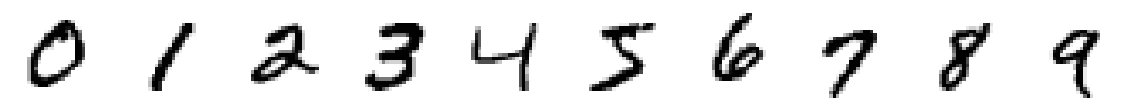

In [16]:
fig, axes = plt.subplots(1, 10)
fig.set_figheight(5)
fig.set_figwidth(20)

for digit in range(10):
    # get index of digit
    idx = list(y).index(digit)
    
    # reshape values and plot
    digit_image = X.iloc[idx].values.reshape(28,28)
    axes[digit].imshow(digit_image, cmap="binary")
    axes[digit].axis('off')

### 3. Use PCA to retrieve 1st and 2nd PC and output explained variance ratio

In [17]:
from sklearn.decomposition import PCA

# create PCA instance with two PCs
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)    
df_X2D = pd.DataFrame(X2D)

# retrieve 1th and 2nd PCs
first_PC = df_X2D[0]
second_PC = df_X2D[1]
print('First PC: \n', first_PC, '\n')
print('Second PC: \n', second_PC, '\n')

# get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print('Explained Variance Ratio: ', explained_variance_ratio)

First PC: 
 0         122.252465
1        1010.492946
2         -58.994140
3        -796.963788
4        -391.319844
            ...     
69995     305.693841
69996     569.185730
69997    -271.507954
69998    -310.223431
69999    1058.861155
Name: 0, Length: 70000, dtype: float64 

Second PC: 
 0       -316.273716
1       -289.982303
2        393.731907
3       -607.393701
4        729.774067
            ...    
69995   -549.650606
69996   -699.030375
69997    590.063489
69998   -116.707997
69999    -83.412452
Name: 1, Length: 70000, dtype: float64 

Explained Variance Ratio:  [0.09746116 0.07155445]


### 4. Plot the projections of PCs onto a 1D hyperplance

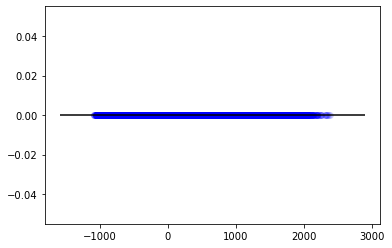

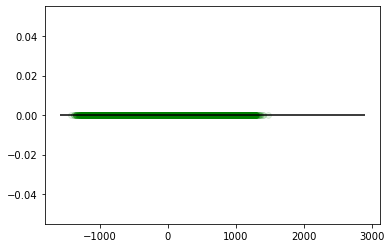

In [18]:
# set range of horizontal line
horizontal_min = min(first_PC) - 500
horizontal_max = max(first_PC) + 500

# project first PC onto 1D hyperplane
plt.figure()
plt.hlines(0, horizontal_min, horizontal_max, colors='black')
plt.scatter(first_PC, np.zeros((1, 70000)), c='blue', alpha=0.1)
plt.show()

# project second PC onto 1D hyperplane    
plt.figure()
plt.hlines(0, horizontal_min, horizontal_max, colors='black')
plt.scatter(second_PC, np.zeros((1, 70000)), c='green', alpha=0.1)
plt.show()

### 5. Use incremental PCA to reduce the dimensionality to 154

In [19]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X)

### 6. Display the original and compressed digits

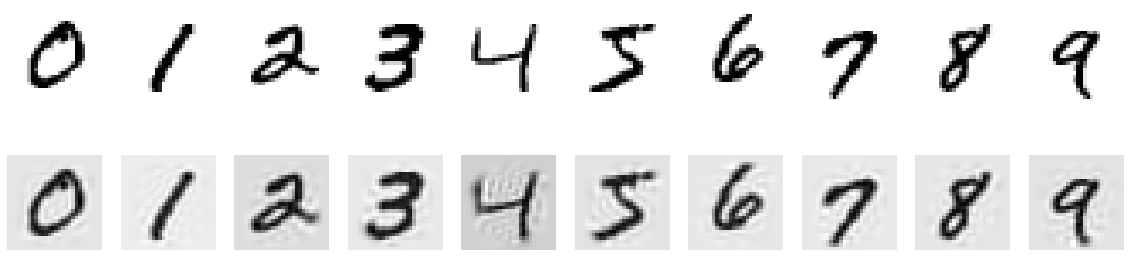

In [20]:
#decompress reduced data to 784 dimentions
X_recovered = pd.DataFrame(inc_pca.inverse_transform(X_reduced))

fig, axes = plt.subplots(2, 10)
fig.set_figheight(5)
fig.set_figwidth(20)

for digit in range(10):
    # get index of digit
    idx = list(y).index(digit)
    
    # reshape values and plot original digit
    idx = list(y).index(digit)
    digit_image = X.iloc[idx].values.reshape(28,28)
    axes[0, digit].imshow(digit_image, cmap="binary")
    axes[0, digit].axis('off')
    
    # reshape values and plot original digit
    idx = list(y).index(digit)
    digit_image = X_recovered.iloc[idx].values.reshape(28,28)
    axes[1, digit].imshow(digit_image, cmap="binary")
    axes[1, digit].axis('off')

<h1 style="color:blue">Question 2</h1>

### 1. Generate Swiss roll dataset.

In [21]:
from sklearn.datasets import make_swiss_roll
X, y = make_swiss_roll(1500)

### 2. Plot the resulting generated Swiss

Text(0.5, 0.92, 'Swiss roll')

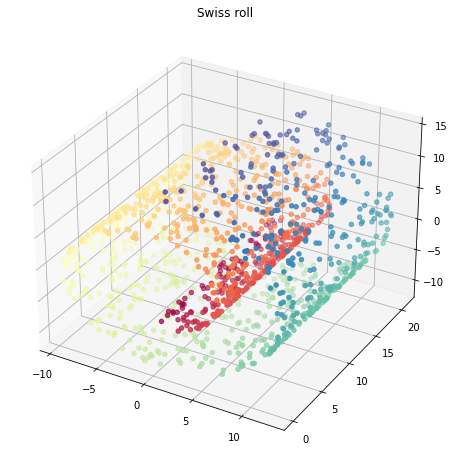

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y, cmap='Spectral')
ax.set_title('Swiss roll')

### 3. Use kPCA with linear, RBF, and sigmoid kernels

In [23]:
from sklearn.decomposition import KernelPCA

# linear kernel
linear_pca = KernelPCA(n_components = 2, kernel="linear")
X_linear = pd.DataFrame(linear_pca.fit_transform(X))

# rbf kernel
rbf_pca = KernelPCA(n_components = 2, kernel='rbf', gamma=0.04)
X_rbf = pd.DataFrame(rbf_pca.fit_transform(X))

# sigmoid kernel
sigmoid_pca = KernelPCA(n_components = 2, kernel='sigmoid', gamma=0.001, coef0=1)
X_sigmoid = pd.DataFrame(sigmoid_pca.fit_transform(X))

### 4. Plot the kPCA results

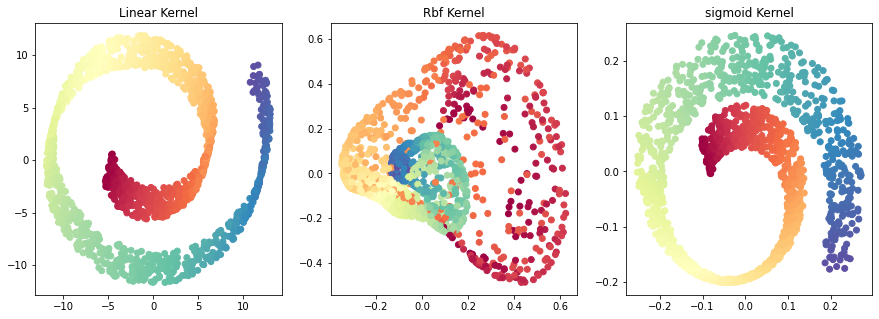

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# linear kernel
axes[0].scatter(X_linear[0], X_linear[1], c=y, cmap='Spectral')
axes[0].title.set_text('Linear Kernel')

# rbf kernel
axes[1].scatter(X_rbf[0], X_rbf[1], c=y, cmap='Spectral')
axes[1].title.set_text('Rbf Kernel')

# sigmoid kernel
axes[2].scatter(X_sigmoid[0], X_sigmoid[1], c=y, cmap='Spectral')
axes[2].title.set_text('sigmoid Kernel')

### 5. Apply Logistic Regression for classification

In [25]:
# Compute unstructured hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X)
label = ward.labels_

# Apply kPCA and Logistic Regression for Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


full_pipeline = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("lr", LogisticRegression(solver='lbfgs', max_iter=500))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.01, 0.5, 10),
        "kpca__kernel": ["linear", "rbf", "sigmoid"],
    }]

grid_search = GridSearchCV(full_pipeline, param_grid)
grid_search.fit(X, label)

# Best parametors and estimator
best_parameters = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print('Best parameters: ', best_parameters)
print('Best estimator: ', best_estimator)

Best parameters:  {'kpca__gamma': 0.44555555555555554, 'kpca__kernel': 'sigmoid'}
Best estimator:  Pipeline(steps=[('kpca',
                 KernelPCA(gamma=0.44555555555555554, kernel='sigmoid',
                           n_components=2)),
                ('lr', LogisticRegression(max_iter=500))])


### 6. Plot the results using GridSearchCV

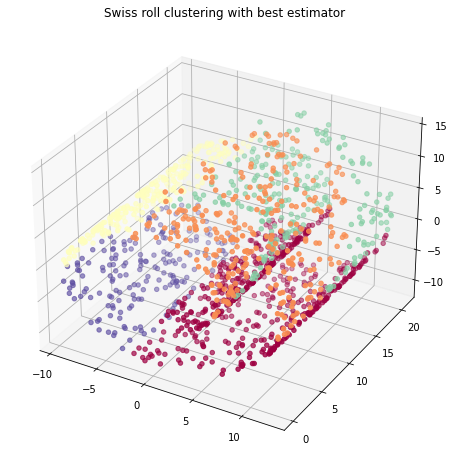

Text(0.5, 1.0, 'Swiss roll clustering in 2D with best estimator ')

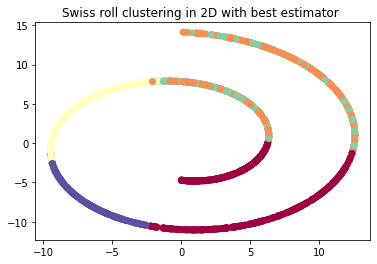

In [26]:
y_pred = best_estimator.predict(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y_pred, cmap='Spectral')
ax.set_title('Swiss roll clustering with best estimator')
plt.show()

plt.scatter(X[:,0], X[:,2], c=y_pred, cmap='Spectral')
plt.title('Swiss roll clustering in 2D with best estimator ')